# Lab 1 - Training a Machine Learning Model

The goal of this lab is to demonstarte how to use Azure Machine Learning service to orchestrate machine learning **training** workflows. 

To keep the focus of the lab on **workflow orchestration** rather then on idiosyncrasies of a domain problem, we have chosen a relatively simple machine learning scenario.

During the lab you will learn how to:
- Track training iterations a.k.a *Runs* in *Azure ML Experiment*
- Execute training scripts on remote, cloud compute resources - *Azure ML Compute*.
- Register the best performing model with *Azure ML Model Registry*


## Scenario

You will train a binary classification model to predict propensity to purchase. The dataset comes from the UCI Machine Learning repository, and it is related to direct marketing campaigns (phone calls) of a Portuguese banking institution. The goal of the model is to help with campaign planning by predicting which clients will respond positively to marketing phone calls. 


## Connect AML workspace

Check the version of AML SDK.

In [1]:
# Verify AML SDK Installed

import azureml.core
print("SDK Version:", azureml.core.VERSION)

SDK Version: 1.0.6


Connect to the workspace.

In [2]:
from azureml.core import Workspace

# Connect to workspace

ws = Workspace.from_config()
print(ws.name, ws.resource_group, ws.location, ws.subscription_id, sep='\n')

Found the config file in: /data/home/demouser/notebooks/aml_config/config.json
jkamlworkshop
jkamlworkshop
southcentralus
952a710c-8d9c-40c1-9fec-f752138cc0b3


## Data preparation
### Download the dataset
The dataset used in the lab can be downloaded from a public Azure Blob Storage container.


In [3]:
import os

folder = '../datasets'
filenames = ['banking_train.csv','banking_test.csv']
os.makedirs(folder, exist_ok=True)
for filename in filenames:
    downloadCommand = 'wget -O ''{0}/{1}'' ''https://azureailabs.blob.core.windows.net/banking/{1}'''.format(folder, filename)
    print(downloadCommand)
    os.system(downloadCommand)
os.listdir(folder)

wget -O ../datasets/banking_train.csv https://azureailabs.blob.core.windows.net/banking/banking_train.csv
wget -O ../datasets/banking_test.csv https://azureailabs.blob.core.windows.net/banking/banking_test.csv


['banking_test.csv', 'banking_train.csv']

### Explore the dataset


In [4]:
import numpy as np
import pandas as pd
import os

folder = '../datasets'
filename = 'banking_train.csv'
pathname = os.path.join(folder, filename)
df = pd.read_csv(pathname, delimiter=',')
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32950 entries, 0 to 32949
Data columns (total 21 columns):
age               32950 non-null int64
job               32950 non-null object
marital           32950 non-null object
education         32950 non-null object
default           32950 non-null object
housing           32950 non-null object
loan              32950 non-null object
contact           32950 non-null object
month             32950 non-null object
day_of_week       32950 non-null object
duration          32950 non-null int64
campaign          32950 non-null int64
pdays             32950 non-null int64
previous          32950 non-null int64
poutcome          32950 non-null object
emp_var_rate      32950 non-null float64
cons_price_idx    32950 non-null float64
cons_conf_idx     32950 non-null float64
euribor3m         32950 non-null float64
nr_employed       32950 non-null float64
y                 32950 non-null int64
dtypes: float64(5), int64(6), object(10)
memory usag

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,33,technician,married,professional.course,no,yes,no,telephone,jul,mon,...,17,999,0,nonexistent,1.4,93.918,-42.7,4.960,5228.1,0
1,31,unemployed,married,university.degree,no,yes,no,cellular,aug,wed,...,11,999,0,nonexistent,1.4,93.444,-36.1,4.964,5228.1,0
2,41,self-employed,married,basic.9y,no,yes,no,cellular,jul,fri,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,0
3,29,admin.,single,university.degree,no,no,yes,cellular,jul,thu,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.958,5228.1,1
4,39,admin.,divorced,high.school,no,yes,no,cellular,jul,mon,...,5,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,0


The dataset combines the information about the bank's customers with the results of previous campaigns and key economic indicators. It includes 41,188 records and 21 fields. The columns are a mix of numeric and categorical data types.

The `y` column indicates whether the customer subscribed to a term deposit. This is our `target` variable or `label`. The goal of the model is to predict this column on new examples.

Some information that exists in the historical dataset will not be available when planning a new campaign. 

Please refer to [UCI ML Repository](https://archive.ics.uci.edu/ml/datasets/bank+marketing) for more information. 

We will use the following features for training. 

In [5]:
feature_columns = [
                   # Demographic
                   'age', 
                   'job', 
                   'education', 
                   'marital',  
                   'housing', 
                   'loan', 
                   # Previous campaigns
                   'month',
                   'campaign',
                   'poutcome',
                   # Economic indicators
                   'emp_var_rate',
                   'cons_price_idx',
                   'cons_conf_idx',
                   'euribor3m',
                   'nr_employed']

df_train = df[feature_columns + ['y']]
df_train.head()

,age,job,education,marital,housing,loan,month,campaign,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,33,technician,professional.course,married,yes,no,jul,17,nonexistent,1.4,93.918,-42.7,4.960,5228.1,0
1,31,unemployed,university.degree,married,yes,no,aug,11,nonexistent,1.4,93.444,-36.1,4.964,5228.1,0
2,41,self-employed,basic.9y,married,yes,no,jul,2,nonexistent,1.4,93.918,-42.7,4.962,5228.1,0
3,29,admin.,university.degree,single,no,yes,jul,2,nonexistent,1.4,93.918,-42.7,4.958,5228.1,1
4,39,admin.,high.school,divorced,yes,no,jul,5,nonexistent,1.4,93.918,-42.7,4.962,5228.1,0


`Scikit-learn` estimators expect continuous input. Some of the features in the dataset are categorical and encoded as strings. We will use *dummy* encoding to convert categorical features to numeric values.

In [6]:
df_train = pd.get_dummies(df_train, drop_first=True).astype(dtype='float')

Let's now look at the class distribution in training data.

([<matplotlib.axis.XTick at 0x7ff9efea8710>,
 <a list of 2 Text xticklabel objects>)

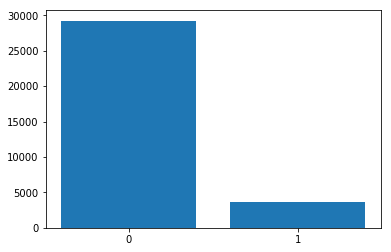

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.bar([0, 1], df_train.y.value_counts())
plt.xticks([0, 1], [0, 1])

The training dataset is very imbalanced. We will need to address this when configuring training.

## Train the model

In this section of the lab you will train a binary classification model.

You will first run training on a local workstation and use Azure Machine Learning Experiment to track training progress. In the following step, you will use Azure Machine Learning Compute to run  training on more powerful cloud compute resources.

In the Azure Machine Learning service, you can track training artifacts (algorithm settings, performance metrics, logs, serialized models, etc.)  created during training iterations a.k.a *Runs* using Azure ML *Experiment*. To do that you must instrument your code with logging statements and trigger logging when you submit the *Run*. The following are two ways to trigger the run submission:

- Start an interactive logging session in the specified *Experiment*. As you execute logging statements, any artifacts that are logged during the session are added to the run record in the experiment. We will use this approach when training the model on a local compute.

- Add logging functions to your training script and trigger logging when submitting the script to run on a compute target. With this option, you can add monitoring code to be notified of completion or to get a visual widget to monitor. We will demonstrate this approach when training on a remote Azure Machine Learning Compute.

### Train on a local workstation
#### Prepare training pipeline

We are going to train a binomial *LogisticRegression* regression model. *LogisticRegression* exposes a number of tuneable hyperparameters. Argueable, the most important setting is the inverse of regularization strength **C** . For the sake of simplicity, we will focus on tuning this hyperparameter when training our model. We will use *GridSearchCV* to automate the hyperparameter tuning process. 

The business goal of our model is to identify customers with high propencity to buy. As such, we want to minimize the number of false negatives - customers who were wrongly identified as ones with low propencity to buy. We want the model with a high *recall*.

Since the dataset is imbalanced we will set *class_weight* parameter to `balanced` to automatically adjust weights inversely proportional to class frequencies in in the input data.


In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


# Create logistic regression estimater
lr = LogisticRegression(solver='lbfgs', max_iter=300, class_weight='balanced')

# Logistic regression requires feature scaling
scaler = StandardScaler()

# Create a training pipeline
pipeline = Pipeline(steps=[('scaler', scaler),
                           ('lr', lr)])

# Configure grid search
param_grid = {'lr__C': [0.1, 0.5, 1, 2, 5]}
clf = GridSearchCV(pipeline,
                   param_grid, 
                   cv=5, 
                   scoring=['recall', 'accuracy'],
                   refit = 'recall',
                   return_train_score = False
                   )


####  Execute training

In [9]:
X = df_train.drop('y', axis=1)
y = df_train.y

clf.fit(X, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lr', LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=300,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'lr__C': [0.1, 0.5, 1, 2, 5]}, pre_dispatch='2*n_jobs',
       refit='recall', return_train_score=False,
       scoring=['recall', 'accuracy'], verbose=0)

#### Track the run in Azure Machine Learning Experiment

The training run has completed and the *GridSearchCV* object contains the results for each value of **C**.

We will now persists the results in *Azure ML Experiment*.

An experiment is a grouping of many runs from a specified script. It always belongs to a workspace. 

Create an *Experiment* to track run records.

In [10]:
from azureml.core.experiment import Experiment

exp = Experiment(ws, "propensity_to_buy_classifier_local_training")

Since we used *GridSearchCV* to train multiple models with different setting for **C** we want to reflect this approach in a run record. One way to do that is to create a hierarcical run record structure mapping directly to our grid search training regime. 

In [11]:
from azureml.core.run import Run

# Create a root run
root_run = exp.start_logging()

# Retrieve training results from GridSearchCV object and store them in child runs of the root run
for C, accuracy, recall in zip(clf.cv_results_['params'], clf.cv_results_['mean_test_accuracy'], clf.cv_results_['mean_test_recall']):
    run = root_run.child_run("Run with C set to {}".format(C))
    run.log("C", C['lr__C'])
    run.log("Accuracy", accuracy)
    run.log("Recall", recall)
    run.complete()
    print("Storing C: {} and accuracy: {} and recall: {} in Run object".format(C['lr__C'], accuracy, recall))
    
# Close the parent run in the experiment
root_run.complete()

Storing C: 0.1 and accuracy: 0.8260698027314113 and recall: 0.6298524017960675 in Run object
Storing C: 0.5 and accuracy: 0.8271623672230652 and recall: 0.6287739945550839 in Run object
Storing C: 1 and accuracy: 0.8274051593323217 and recall: 0.6287739945550839 in Run object
Storing C: 2 and accuracy: 0.8274051593323217 and recall: 0.6282355548538359 in Run object
Storing C: 5 and accuracy: 0.8274962063732929 and recall: 0.6282355548538359 in Run object


Now that you have captured history for various runs, you can review the runs. 

There are three ways to access information captured in *Azure ML Experiment*:

- Using Azure ML Workspace web GUI in Azure Portal
- Using Azure ML CLI
- Programatically, using Azure ML SDK.


In [12]:
# List all child runs
runs = [r for r in root_run.get_children()]

for run in runs:
    print(run.get_details())
    print(run.get_metrics())
    print("-" * 60)

{'runId': '4d9d9c99-c3b7-42c7-8b96-2a64ecc431a8', 'target': 'sdk', 'status': 'Completed', 'startTimeUtc': '2019-01-15T17:05:46.124863Z', 'endTimeUtc': '2019-01-15T17:05:46.558285Z', 'properties': {}, 'logFiles': {}}
{'C': 5, 'Accuracy': 0.8274962063732929, 'Recall': 0.6282355548538359}
------------------------------------------------------------
{'runId': 'f62b6fd8-9a54-468f-8e8b-2017d6a7f4a0', 'target': 'sdk', 'status': 'Completed', 'startTimeUtc': '2019-01-15T17:05:45.315471Z', 'endTimeUtc': '2019-01-15T17:05:45.67973Z', 'properties': {}, 'logFiles': {}}
{'C': 2, 'Accuracy': 0.8274051593323217, 'Recall': 0.6282355548538359}
------------------------------------------------------------
{'runId': '175bcd35-1797-41db-9f5f-f152f6df6df7', 'target': 'sdk', 'status': 'Completed', 'startTimeUtc': '2019-01-15T17:05:44.580425Z', 'endTimeUtc': '2019-01-15T17:05:44.95823Z', 'properties': {}, 'logFiles': {}}
{'C': 1, 'Accuracy': 0.8274051593323217, 'Recall': 0.6287739945550839}
-------------------

### Train remotely using Azure ML Compute

Up until now, all of your training was executed locally on the same machine running Jupyter. Now you will execute the same logic targeting a remote Azure ML Compute.

A compute target is the compute resource that you use to run your training script or host your service deployment. Compute targets are attached to a workspace. Compute targets other than the local machine are shared by users of the workspace.

There are two types of compute targets: managed and unmanaged:

- **Managed**: Compute targets that are created and managed by Azure Machine Learning service. These compute targets are optimized for machine learning workloads. Currently, Azure Machine Learning Compute is the only managed compute target. Additional managed compute targets may be added in the future. You can create machine learning compute instances directly through the workspace by using the Azure portal, the Azure Machine Learning SDK, or the Azure CLI. All other compute targets must be created outside the workspace and then attached to it.

- **Unmanaged**: Compute targets that are not managed by Azure Machine Learning service. You might need to create them outside Azure Machine Learning and then attach them to your workspace before use. Unmanaged compute targets can require additional steps for you to maintain or to improve performance for machine learning workloads.

In this lab we are going to utilize Azure Machine Learning Compute.


#### Provision Azure ML Compute Cluster

We will provision an autoscale Azure ML Computer Cluster. In this lab we will only use a single node on the cluster. In the following labs we will utilize multiple nodes on the cluster to run parallel model selection and hyper parameter tuning jobs.

In [13]:
# Create an Azure ML Compute cluster

# Create Azure ML cluster
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget
import os

# choose a name for your cluster
cluster_name = "cpu-cluster"
cluster_min_nodes = 1
cluster_max_nodes = 3
vm_size = "STANDARD_DS11_V2"

# Check if the cluster exists. If yes connect to it
if cluster_name in ws.compute_targets:
    compute_target = ws.compute_targets[cluster_name]
    if compute_target and type(compute_target) is AmlCompute:
        print('Found existing compute target, using this compute target instead of creating:  ' + cluster_name)
    else:
        print("Error: A compute target with name ",cluster_name," was found, but it is not of type AmlCompute.")
else:
    print('Creating a new compute target...')
    provisioning_config = AmlCompute.provisioning_configuration(vm_size = vm_size, 
                                                                min_nodes = cluster_min_nodes, 
                                                                max_nodes = cluster_max_nodes)

    # create the cluster
    compute_target = ComputeTarget.create(ws, cluster_name, provisioning_config)
    
    # can poll for a minimum number of nodes and for a specific timeout. 
    # if no min node count is provided it will use the scale settings for the cluster
    compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)
    
     # For a more detailed view of current BatchAI cluster status, use the 'status' property    
    print(compute_target.status.serialize())

Creating a new compute target...
Creating
Succeeded............
AmlCompute wait for completion finished
Minimum number of nodes requested have been provisioned
{'allocationState': 'Steady', 'allocationStateTransitionTime': '2019-01-15T17:08:24.739000+00:00', 'creationTime': '2019-01-15T17:06:45.452061+00:00', 'currentNodeCount': 1, 'errors': None, 'modifiedTime': '2019-01-15T17:07:24.129871+00:00', 'nodeStateCounts': {'idleNodeCount': 0, 'leavingNodeCount': 0, 'preemptedNodeCount': 0, 'preparingNodeCount': 1, 'runningNodeCount': 0, 'unusableNodeCount': 0}, 'provisioningState': 'Succeeded', 'provisioningStateTransitionTime': None, 'scaleSettings': {'minNodeCount': 1, 'maxNodeCount': 3, 'nodeIdleTimeBeforeScaleDown': 'PT120S'}, 'targetNodeCount': 1, 'vmPriority': 'Dedicated', 'vmSize': 'STANDARD_DS11_V2'}


#### Upload data to AML DataStore
With your cluster ready, you need to upload the training data to a location accessible by the cluster's nodes. 

*Datastore* is a storage abstraction over an Azure storage account. The datastore can use either an Azure blob container or an Azure file share as the back-end storage. Each workspace has a default datastore, and you can register additional datastores.

We will upload the training data to the default Datastore.

In [14]:
# Upload the dataset to the DataStore

ds = ws.get_default_datastore()
print(ds.datastore_type, ds.account_name, ds.container_name)
ds.upload(src_dir='../datasets', target_path='datasets', overwrite=True, show_progress=True)

AzureBlob jkamlworstoragedirzndtd azureml-blobstore-5635fa3a-71d5-4d1b-bc80-b0847d6f842b
Uploading ../datasets/banking_test.csv
Uploading ../datasets/banking_train.csv
Uploaded ../datasets/banking_test.csv, 1 files out of an estimated total of 2
Uploaded ../datasets/banking_train.csv, 2 files out of an estimated total of 2


$AZUREML_DATAREFERENCE_e919859c06c24a15b4120214ddc4cd64

#### Create a training script

Next, you will need to create a training script that is similar to the code you have executed to train the model locally. The script will be executed remotely on Azure ML Compute.

In the script we chose not to utilize *GridSearchCV* for hyperparameter tuning. The value of **C** to use in *LogisticRegression* model is passed as a command line parameter. In the next lab, we will demonstrate how to use *Azure ML Hyperdrive* to conduct hyperparameter tuning in parallel on a scale out cluster.

Note that we are passing the location of the training file as a parameter of the script. 

The last few statements in the script copy the serialized model to the `./outputs` directory. The `./outputs` directory is one of the special directories in Azure ML. At the end of each run the contents of the directory is copied to to Azure Machine Learning Experiment associated with the run.

In [15]:
import os
script_folder = './script'
os.makedirs(script_folder, exist_ok=True)

In [16]:
%%writefile $script_folder/train.py

import argparse
import os
import numpy as np
import pandas as pd

from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate

from azureml.core.run import Run

# Retrieve command line arguments
parser = argparse.ArgumentParser()
parser.add_argument('--data-folder', type=str,  help='data folder mounting point')
parser.add_argument('--filename', type=str,  help='training file name')
parser.add_argument('--C', type=float , help='regularization')
args = parser.parse_args()

# Configure a path to training data
data_folder = os.path.join(args.data_folder, 'datasets')
print('Loading data from: ', data_folder)
data_csv_path = os.path.join(data_folder, args.filename)

# Load the dataset
df = pd.read_csv(data_csv_path)

# Preprocess the data
feature_columns = [
                   # Demographic
                   'age', 
                   'job', 
                   'education', 
                   'marital',  
                   'housing', 
                   'loan', 
                   # Previous campaigns
                   'month',
                   'campaign',
                   'poutcome',
                   # Economic indicators
                   'emp_var_rate',
                   'cons_price_idx',
                   'cons_conf_idx',
                   'euribor3m',
                   'nr_employed']

df = df[feature_columns + ['y']]
df_train = pd.get_dummies(df, drop_first=True).astype(dtype='float')

# Create logistic regression estimater
lr = LogisticRegression(solver='lbfgs', C=args.C, max_iter=300, class_weight='balanced')

# Logistic regression requires feature scaling
scaler = StandardScaler()

# Create a training pipeline
pipeline = Pipeline(steps=[('scaler', scaler),
                           ('lr', lr)])


# Train and evaluate the model using cross validation
X = df_train.drop('y', axis=1)
y = df_train.y

# Evaluate mterics(s) by cross-validation
print("Starting training ...")
scoring = ['accuracy', 'recall']
scores = cross_validate(pipeline, X, y, 
                        cv=10, 
                        return_train_score=False,
                        scoring=scoring)

cv_accuracy = np.mean(scores['test_accuracy'])
cv_recall = np.mean(scores['test_recall'])

print("CV accuracy: ", cv_accuracy)
print("CV recall: ", cv_recall)

# Persist the metrics in Azure ML Experiment
# Acquire the current run and log run parameters and performance measures
run = Run.get_context()
run.log("C", args.C)
run.log("CV Accuracy", cv_accuracy)
run.log("CV Recall", cv_recall)


# Train the model on a full dataset
trained_pipeline = pipeline.fit(X, y)

# Serialize the model to ./outputs directory so that it can be automatically copied to Azure ML Experiment
print("Saving the model to outputs ...")
joblib.dump(value=trained_pipeline, filename='outputs/model.pkl')


Writing ./script/train.py


#### Configure a remote job

A run configuration is a set of instructions that defines how a script should be run in a specified compute target. The configuration includes a wide set of behavior definitions, such as whether to use an existing Python environment or to use a Conda environment that's built from a specification.

There are different ways of specifing a run configuration. We will use a higher level abstraction - the *Estimator*.

The *Estimator* class allows to easily train models in the Azure ecosystem. You can create and use an Estimator object to submit any training code you want to run on remote compute, whether it's a single-node run or distributed training across a GPU cluster. For PyTorch and TensorFlow jobs, Azure Machine Learning also provides respective custom PyTorch and TensorFlow estimators to simplify using these frameworks.

Notice that we are using `ds.as_mount()` method to pass a location of the training dataset on the default *Datastore* to the *Estimator* object.


In [17]:
# Create estimator
#############################
from azureml.train.estimator import Estimator

script_params = {
    '--data-folder': ds.as_mount(),
    '--filename': 'banking_train.csv',
    '--C': 2
}

est_config = Estimator(source_directory=script_folder,
                       script_params=script_params,
                       compute_target=compute_target,
                       entry_script='train.py',
                       conda_packages=['scikit-learn', 'pandas'])

#### Submit the job

Submit the job using the submit() method of the Experiment object. 

In [18]:
#  Execute the estimator job
#####################################

# Create a new experiment
from azureml.core import Experiment
experiment_name = "propensity_to_buy_classifier_remote_training"
exp = Experiment(workspace=ws, name=experiment_name)

# Submit the run
tags = {"Compute target": "Azure ML Compute"}
run = exp.submit(config=est_config, tags=tags)
run


Experiment,Id,Type,Status,Details Page,Docs Page
propensity_to_buy_classifier_remote_training,propensity_to_buy_classifier_remote_training_1547572151850,azureml.scriptrun,Queued,Link to Azure Portal,Link to Documentation


#### Monitor a remote run

The call to start the run is asynchronous, it returns a **Starting** state as soon as the job is started.

The first run takes longer. The subsequent runs, as long as the script dependencies don't change, are much faster.

Here is what's happening while you wait:

- **Image creation**: A Docker image is created matching the Python environment specified by the estimator. In our case, this will be a base CPU image with the  `scikit-learn`, and `pandas` libraries. The image is uploaded to the workspace. This stage happens once for each Python environment since the container is cached for subsequent runs.  During image creation, logs are streamed to the run history. You can monitor the image creation progress using these logs.

- **Running**: In this stage, the training script is sent to the remote Azure ML Compute, then the data in the default datastore is copied to the local storage on the cluster node , then the script is run. While the job is running, stdout and the ./logs directory are streamed to the run history. You can monitor the run's progress using these logs. 

- **Post-Processing**:  The ./outputs directory on the cluster node  is copied over to the run history in the workspace.

You can check the progress of a running job in multiple ways. Below cells demonstrate how to use a Jupyter widget as well as a `wait_for_completion` method. 

In [19]:
from azureml.widgets import RunDetails

# Create a monitoring widget
RunDetails(run).show()


_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': True, 'log_level': 'INFO', 's…

In [ ]:
# Poll for job status
run.wait_for_completion(show_output=True)  # value of True will display a verbose, streaming log


#### Display files stored with the run

In [ ]:
print(run.get_file_names())

### Next steps

In the next lab you will used *Azure ML Hyperdrive* to fine tune hyperparameters on a scale out cluster.